# Matching Pursuit

Import

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from skimage import draw
from scipy import signal
from PIL import Image
import pywt
import pywt.data
import scipy.stats as stats

Functions

In [2]:
def fun_conv(A,B):
    conv = signal.fftconvolve(A,B,mode='same')
    return conv

def fun_auto(A):
    auto = signal.fftconvolve(A,np.flip(A),mode='same')
    return auto

def imshowarray(arr):
    plt.imshow((arr,arr))
    plt.ylim([0,1])

Sparse vector a

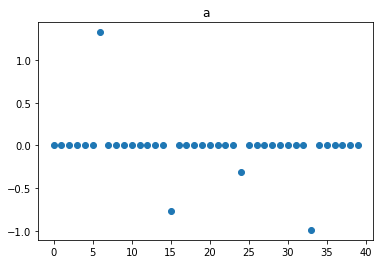

[ 0.          0.          0.          0.          0.          0.
  1.32921217  0.          0.          0.          0.          0.
  0.          0.          0.         -0.77003345  0.          0.
  0.          0.          0.          0.          0.          0.
 -0.31628036  0.          0.          0.          0.          0.
  0.          0.          0.         -0.99081039  0.          0.
  0.          0.          0.          0.        ]


In [3]:
#defining vector a
np.random.seed(24)
a_values = np.random.normal(0, 1, 4)
d = 40
a_real = np.zeros(d)
for a_val in range(len(a_values)):
    a_real[6+9*a_val] = a_values[a_val]

plt.plot(range(d),a_real,'o')
plt.title('a')
plt.show()
print(a_real)

PSF vector h

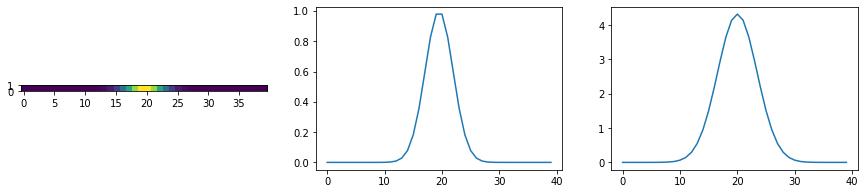

In [4]:
h_x = np.linspace(-d*2,d*2,d)

h_sig=10
h = np.exp(-h_x**2/(2*h_sig**2))

# h -= h.mean()

plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
imshowarray(h)
plt.subplot(1,3,2)
plt.plot(range(d),h)
plt.subplot(1,3,3)
plt.plot(range(d),fun_auto(h))
plt.show()


Offline computation

In [5]:
#Offline computation




theta_array = np.zeros((d,d),float)
# Theta = np.zeros(d,d)
weight_array = np.zeros(d)
for a_ii in range(d):
    #step 0
    e = np.zeros((d,1),dtype=float)
    e[a_ii] = 1
    #step 1
    phi_i = pywt.idwt(e,None,wavelet='db1')[:,0]
    #step 2
    theta_i = fun_conv(h,phi_i)
    theta_array[:,a_ii] = theta_i
    # Theta[:,i] = theta_i
    #step 3
    weight_i = 1/np.linalg.norm(theta_i)
    weight_array[a_ii] = weight_i
    print(weight_array)

# i_theta = 0
# plt.imshow(theta_array[:,i_theta*d:i_theta*d+d])
# plt.show()
# print(theta_array[:,i_theta*d:i_theta*d+d].shape)


[0.80077251 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.80077251 0.72512086 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.80077251 0.72512086 0.69396057 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         

Output vector x

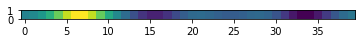

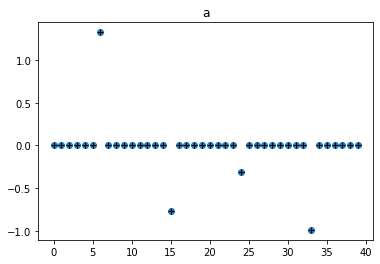

In [6]:
a_2 = (a_real*np.ones((1,d))).T
x = pywt.idwt(a_2,None,wavelet='db1')
y = fun_conv(h,x[:,0])
imshowarray(y)
plt.show()

a_recover = pywt.dwt(x,wavelet='db1')[0]
plt.plot(range(d),a_real,'o')
plt.plot(range(d),a_recover,'k+')

plt.title('a')
plt.show()

MP loop

<r_(k+1),Θ_i*> = 0.0, ans: -5.176456568687445e-16
<r_(k+1),Θ_i*> = 0.0, ans: 1.192622389734055e-16
<r_(k+1),Θ_i*> = 0.0, ans: 6.844059631911494e-17
<r_(k+1),Θ_i*> = 0.0, ans: -1.5238638964525157e-16


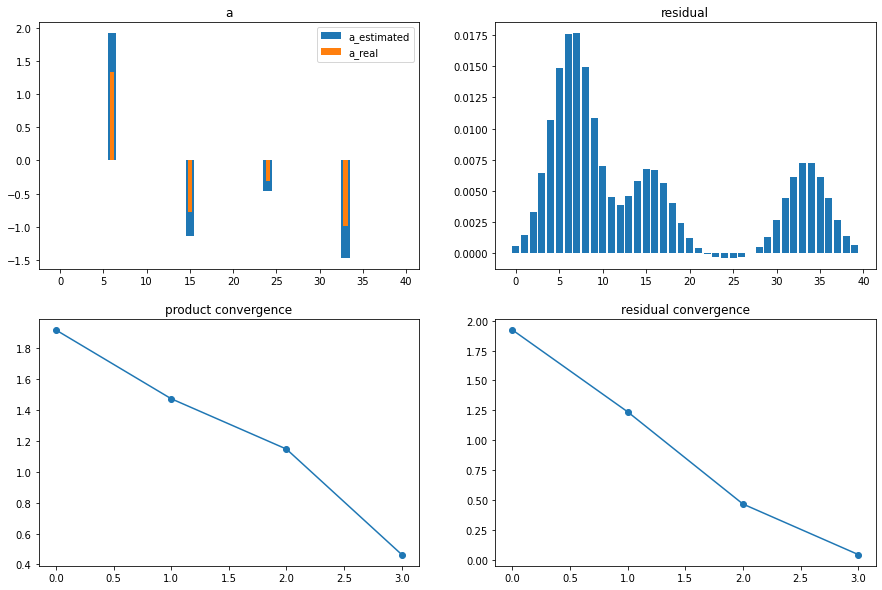

In [7]:
r = y
a = a_real*0
k = 0
s = 4
plotting_product = np.array([])
plotting_residue = np.array([])

while (k<s):
    #atom selection
    arg2max_array = np.zeros(d)
    for i in range(d):
        arg2max = abs(theta_array[:,i:i+1].T@r*weight_array[i])
        # arg2max = abs(weight_array* fun_conv(h,pywt.wavedec(r)))
        arg2max_array[i] = arg2max

    i_star, = np.where(arg2max_array==np.amax(arg2max_array))
    i_star = int(i_star)
    c = theta_array[:,i_star].T@r*weight_array[i_star]

    #coef. update
    e = a*0
    e[i_star]=1
    a = a + c*e

    #residual update
    r = r - c*theta_array[:,i_star]*weight_array[i_star]
    print('<r_(k+1),Θ_i*> = 0.0, ans:',float(r.T@theta_array[:,i_star]))
    

    #plotting elements
    plotting_product = np.append(plotting_product,arg2max_array[i_star])
    plotting_residue = np.append(plotting_residue,np.linalg.norm(r))

    k += 1
    
    # print(np.amax(arg2max_array[0,:]))
    # plt.bar(range(d),arg2max_array[0,:])
    # plt.show()
    # plt.bar(range(d),a[:,0])
    # plt.show()

fig = plt.figure(figsize=(15,10))

fig.add_subplot(2, 2, 1)
plt.bar(range(d), a, width=1, label='a_estimated')
plt.bar(range(d), a_real, width=0.5, label='a_real')
plt.title('a')
plt.legend()

fig.add_subplot(2, 2, 2)
plt.bar(range(d),r)
plt.title('residual')

fig.add_subplot(2, 2, 3)
plt.plot(plotting_product,'o-')
plt.title('product convergence')

fig.add_subplot(2, 2, 4)
plt.plot(plotting_residue,'o-')
plt.title('residual convergence')
plt.show()

In [8]:
arg2max = abs(theta_array[:,i].T@r*weight_array[i])
